In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("abalone_dataset.csv")

In [27]:
df.head()

,Sex_is_male,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,True,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15.0
1,True,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7.0
2,False,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0
3,True,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0
4,False,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0


### EDA

Проверим датасет на пропущенные значения.

In [3]:
df[df.isna().any(axis=1)]

,Sex_is_male,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings


Пропущенных значений в датасете нету.

Построим таблицу корреляции.

In [4]:
df.drop(axis=1, columns=['Sex_is_male']).corr()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole_weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked_weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera_weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell_weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


<Axes: >

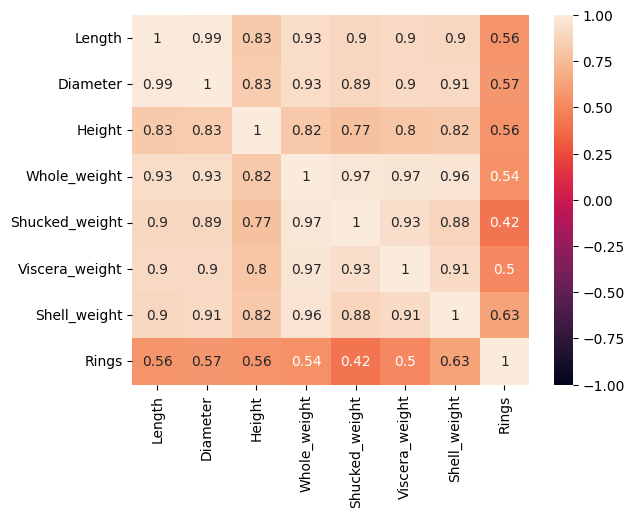

In [5]:
import seaborn as sns

sns.heatmap(df.drop(columns=["Sex_is_male"]).corr(), annot=True, vmin=-1)

Как видно, у всех численных величин умеренно сильная корреляция с целевой переменной, так что нет особого реззона какую-либо убирать. Кроме того, некоторые из фичей сильно скоррелированы друг с другом, однако это не страшно, если использовать методы, основанные на деревьях.

В датасете только одна категориальная переменная - пол абалона. Посмотрим на ращличия в распределении для каждого пола.

In [6]:
import matplotlib.pyplot as plt

In [7]:
df_male = df[df["Sex_is_male"] == True]
df_female = df[df["Sex_is_male"] == False]

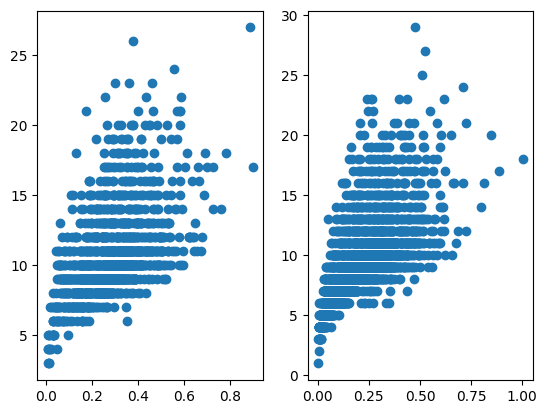

In [8]:
plt.subplot(1, 2, 1)
plt.scatter(df_male["Shell_weight"], df_male["Rings"])
plt.subplot(1, 2, 2)
plt.scatter(df_female["Shell_weight"], df_female["Rings"])

На графике различия в распределении между женскими и мужскими абалонами видно не сильно. Попробуем посмотреть на статистики.

In [9]:
df_male["Rings"].mean(), df_female["Rings"].mean()

(np.float64(10.705497382198953), np.float64(9.488486221215553))

In [10]:
df_male["Rings"].median(), df_female["Rings"].median()

(np.float64(10.0), np.float64(9.0))

Как видно, женские и мужские абалоны действительно отличаются, так что имеет смысл оставить пол. Закодировать её можно при помощи One-Hot-Encoding, так как это самый базовый вариает кодировки категориальных фичей, а у данной категориальной фичи не получается найти каких-либо особо ярких особенностей.

### Feature importance

In [11]:
_random_state = 67

In [12]:
from sklearn.ensemble import AdaBoostRegressor

abr = AdaBoostRegressor(random_state=_random_state)
abr.fit(df.drop(columns=["Rings"]), df["Rings"])
abr.feature_importances_

array([0.0008335 , 0.01737288, 0.07711897, 0.07850495, 0.10597159,
       0.17549879, 0.10567441, 0.43902491])

### Permutation importance

In [13]:
from sklearn.inspection import permutation_importance

np.set_printoptions(suppress=True)
pi_res = permutation_importance(abr, df.drop(columns=["Rings"]), df["Rings"], random_state=_random_state)
pi_res.importances.mean(axis=1)

array([0.00442111, 0.00870338, 0.02511464, 0.21332946, 0.02003742,
       0.41479514, 0.00027579, 0.88668129])

Как видно, оба варианта похожи наполовину. В частности, самой важной оба раза оказалась фича с наибольшей корреляцией с целевой переменной. Ещё три фичи соотносятся примерно олдинаково. Тем не менее, есть несколько фичей (Length, Diameter, Whole weight, Viscera Weight), которые оказались сильно важнее в первом случае, чем во втором.

### Models

In [14]:
from sklearn.model_selection import train_test_split

X, y = df.drop(columns=["Rings"]), df["Rings"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=_random_state)

In [15]:
from sklearn.model_selection import GridSearchCV

def test_model(model, params, data):
    gs_res = GridSearchCV(model, params)
    gs_res.fit(data["X_train"], data["y_train"])
    return gs_res

In [16]:
test_model_data = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test
}

In [17]:
# Модель 1: Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=_random_state)
rf_params = {
    "n_estimators": [100, 150, 250],
    "max_depth": [2, 3, 5, 7],
    "min_impurity_decrease": [0., 0.1, 0.25]
}
rf_res = test_model(rf, rf_params, test_model_data)

In [18]:
rf_res.best_estimator_

,n_estimators,100
,criterion,'squared_error'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
from sklearn.metrics import mean_absolute_percentage_error

rf_pred = rf_res.best_estimator_.predict(test_model_data["X_test"])
mean_absolute_percentage_error(rf_pred, test_model_data["y_test"])

0.15285871123935338

In [31]:
# Модель 2: Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=_random_state)
gb_params = {
    "n_estimators": [50, 100, 175, 250],
    "max_depth": [2, 3, 5],
    "learning_rate": [1., 0.1, 1e-2]
}
gb_res = test_model(gb, gb_params, test_model_data)

In [32]:
gb_res.best_estimator_

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [33]:
gb_pred = gb_res.best_estimator_.predict(test_model_data["X_test"])
mean_absolute_percentage_error(gb_pred, test_model_data["y_test"])

0.15543691471019655

Ошибка на тестовой выборке для обоих моделей почти одинакова. Тем не менее, при одинаковом количестве деревьев в градиентном бустинге меньше максимальная глубина дерева (3 для градиентного бустинга vs. 7 для случайного леса), что демонстрирует то, что случайные леса меньше склонны к переобучению при росте глубины деревьев, их составляющих.